In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import collections

In [42]:
%matplotlib inline

Let's import the item excell file into panda dataframes

In [43]:
items = pd.read_excel("/home/yeshaq/Downloads/item-title.xlsx")

In [44]:
len(items) 

98180

Ok..about 100k items

In [45]:
items.head()

,item_id1,META_CATEG_NAME,LEAF_CATEG_ID,AUCT_TITL,SLR_ID
0,291572810442,Home & Garden,117503,Troy Lighting F2058 Sunset Bronze Bristol Bay ...,1089488995
1,381531375722,Home & Garden,117503,Trans Globe Lighting 10140 Polished Chrome 2 L...,1089488995
2,401057145020,Home & Garden,117503,Nuvo Lighting 76/412 White 1 Light Semi-Flush ...,1089488995
3,381415003112,Home & Garden,117503,Cal Lighting FX-3517/6 Warm Bronze / Wood Cruz...,1089488995
4,381415396411,Home & Garden,116880,Hudson Valley Lighting 981 Polished Nickel / W...,1089488995


Hmm...what categories are these items in?

In [46]:
categories = items.groupby("META_CATEG_NAME")

In [47]:
for cat in categories:
    print cat[1][1:2]["META_CATEG_NAME"], "print item count", len(cat[1])

30201    Computers/Tablets & Networking
Name: META_CATEG_NAME, dtype: object print item count 3
246    Consumer Electronics
Name: META_CATEG_NAME, dtype: object print item count 75
1    Home & Garden
Name: META_CATEG_NAME, dtype: object print item count 98101
Series([], Name: META_CATEG_NAME, dtype: object) print item count 1


Over 99% of the items are in the Home & Garden Category

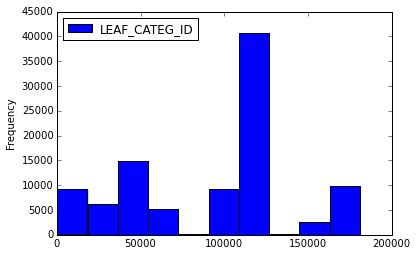

In [48]:
items.plot(kind="hist", y = "LEAF_CATEG_ID")

Most of those items are concentrated in on category leaf!

Let's import the keyword file

In [49]:
kws = pd.read_excel("/home/yeshaq/Downloads/kw.xls")

In [50]:
len(kws)

24992

In [51]:
kws.sort("Search PV(Page 1)", ascending=False).head()

/home/yeshaq/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Keyword,Meta,L2,Search PV(Page 1)
0,iphone 6,15032,9355,465715
11111,iphone 5s,15032,9355,374793
17220,iphone 6s,15032,9355,372893
18328,nike,11450,93427,240346
19438,laptop,58058,175672,233229


Ok..about 25K keywords, with iphone queries leading the pack. 

Create additional column in item table with category and item name combined. 

In [52]:
titles = items.loc[:,["META_CATEG_NAME","AUCT_TITL"]]
def f(x):
    return x[0]+" " + x[1]
items.loc[:,"fullTitle"] = titles.apply(f,axis=1)

Creating helper function to calculate the jaccard similarity function. For now I'm hardcoding words which I do not want in the similarity calculation

In [143]:
def jaccardSimilarity(kw, item):
    toRemove = ["the","and","The","with"]
    kw = kw.split()
    tmp = [x if x not in toRemove else "" for x in kw]
    kw = tmp
    item = item.split()
    cleanedItems = filter(lambda x: len(x)>2,item)
    return float(len(set(kw) & set(cleanedItems)))/len(set(kw) | set(cleanedItems))

Picking a threshold of 1 perecnt, could also pick the top 30% jaccard indeces for a given item. 

In [139]:
def filterJaccard(df,title,jaccardThresholdQ = 0.7, jaccardThreshold= 0.01):
    df.loc[:,"Jaccard"] = df["Keyword"].apply(lambda x : jaccardSimilarity(x,title))
    #return df[df["Jaccard"]>(df["Jaccard"].max())*jaccardThresholdQ ]["Keyword"]
    return df[df["Jaccard"]>=jaccardThreshold ]["Keyword"]


Looping over items and finding the jaccard index for that item and the keyword list. 

In [147]:
frames = []
i = 0
for index, row in items.iterrows():
    if i > 500:
        break
    jSeries = filterJaccard(kws,row["fullTitle"])
    size = len(jSeries)
    if size > 0:
        content = (("Item_Id", [row["item_id1"]]*size),
                 ("Item Title", [row["AUCT_TITL"]]*size), 
                 ("KW", jSeries),
                 ("Meta Categ Id",[row["META_CATEG_NAME"]]*size),
                 ("Item Leaf Category", row["LEAF_CATEG_ID"]*size))
        content = collections.OrderedDict(content)
        tmp = pd.DataFrame(content)
        frames.append(tmp)
    i+=1

In [150]:
final = pd.concat(frames)

In [152]:
final

,Item_Id,Item Title,KW,Meta Categ Id,Item Leaf Category
21953,401000622902,Mirabelle MIRSH2030 Polished Chrome Multi Func...,2.5 sata hard drive,Home & Garden,71282
10707,381444093001,Kohler K-6228 Polished Chrome Wall Mount Kitch...,tales from the crypt,Home & Garden,126072
13237,381444093001,Kohler K-6228 Polished Chrome Wall Mount Kitch...,kut from the kloth,Home & Garden,126072
15916,381444093001,Kohler K-6228 Polished Chrome Wall Mount Kitch...,creature from the black lagoon,Home & Garden,126072
22543,291663674292,Kohler K-8549 Polished Nickel Alterna Deck Mou...,simian spirit guide,Home & Garden,42024
10707,291670844708,Eglo 89568A Chrome 6 Light 1 Tier Chandelier f...,tales from the crypt,Home & Garden,352509
13237,291670844708,Eglo 89568A Chrome 6 Light 1 Tier Chandelier f...,kut from the kloth,Home & Garden,352509
15916,291670844708,Eglo 89568A Chrome 6 Light 1 Tier Chandelier f...,creature from the black lagoon,Home & Garden,352509
10707,291663130150,Dimond Lighting HGTV160 Matte Black 1 Light 23...,tales from the crypt,Home & Garden,337743
13237,291663130150,Dimond Lighting HGTV160 Matte Black 1 Light 23...,kut from the kloth,Home & Garden,337743


This is a very innefficient way of calling the helper functions (about 30 seconds for 500 items). One should really use a combination of apply() on the columns. For now, it will do since i've been passed my alloted time. This excercise is tough because finding a good metric for similarity between a keyword and a (sometimes long) item name can skew the metric. (i.e. the jaccard similarity has the union of the two sets in the denominator)  

The metric needs to be rethought, it's not giving correct (relevant) results yet.